# BIC-based Model Selection for Latent Class Models
## Monte Carlo Simulation Study

This notebook implements BIC-based estimation of the number of latent classes K and evaluates consistency through Monte Carlo simulations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Latent Class Model Implementation

In [2]:
class LatentClassModel:
    """
    Unconditional Latent Class Model for Multivariate Categorical Data
    
    Parameters:
    -----------
    K : int
        Number of latent classes
    m : int
        Number of categorical variables
    C : array-like of shape (m,)
        Number of categories for each variable
    max_iter : int
        Maximum number of EM iterations
    tol : float
        Convergence tolerance
    """
    
    def __init__(self, K, m, C, max_iter=100, tol=1e-6, random_state=None):
        self.K = K
        self.m = m
        self.C = np.array(C) if isinstance(C, (list, tuple)) else np.full(m, C)
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        # Model parameters
        self.pi = None  # Mixture weights (K,)
        self.theta = None  # Component probabilities list of length m, each (K, C_r)
        self.log_likelihood_history = []
        
    def _initialize_parameters(self, X):
        """Initialize parameters randomly"""
        rng = np.random.RandomState(self.random_state)
        
        # Initialize mixture weights uniformly with small perturbations
        self.pi = np.ones(self.K) / self.K + rng.randn(self.K) * 0.01
        self.pi = np.abs(self.pi)
        self.pi /= self.pi.sum()
        
        # Initialize theta with Dirichlet distribution
        self.theta = []
        for r in range(self.m):
            # Dirichlet with concentration parameter 1 (uniform)
            theta_r = rng.dirichlet(np.ones(self.C[r]), size=self.K)
            self.theta.append(theta_r)
            
    def _e_step(self, X):
        """
        E-step: Compute posterior probabilities gamma_ik
        
        Returns:
        --------
        gamma : array of shape (n, K)
            Posterior probabilities
        """
        n = X.shape[0]
        
        # Compute log probabilities in numerically stable way
        # a_ik = log(pi_k) + sum_r log(theta_rkc) where c = X_i^(r)
        log_pi = np.log(self.pi + 1e-10)  # Shape (K,)
        
        # Vectorized computation of log probabilities
        a = np.tile(log_pi, (n, 1))  # Shape (n, K)
        
        for r in range(self.m):
            # X[:, r] contains category indices for variable r
            # theta[r] has shape (K, C_r)
            # We need theta[r][k, X[i, r]] for all i, k
            log_theta_r = np.log(self.theta[r] + 1e-10)  # Shape (K, C_r)
            # Advanced indexing: for each sample i and class k, get log_theta[k, X[i,r]]
            a += log_theta_r[:, X[:, r]].T  # Shape (n, K)
        
        # Normalize using log-sum-exp trick
        # gamma_ik = exp(a_ik - M_i) / sum_j exp(a_ij - M_i)
        M = a.max(axis=1, keepdims=True)  # Shape (n, 1)
        a_shifted = a - M
        exp_a = np.exp(a_shifted)
        gamma = exp_a / exp_a.sum(axis=1, keepdims=True)
        
        return gamma
    
    def _m_step(self, X, gamma):
        """
        M-step: Update parameters
        
        Parameters:
        -----------
        X : array of shape (n, m)
            Data
        gamma : array of shape (n, K)
            Posterior probabilities from E-step
        """
        n = X.shape[0]
        
        # Update mixture weights
        self.pi = gamma.mean(axis=0)
        
        # Update theta for each variable
        for r in range(self.m):
            # For each class k and category c
            theta_r = np.zeros((self.K, self.C[r]))
            
            for c in range(self.C[r]):
                # Indicator: X[:, r] == c
                indicator = (X[:, r] == c).astype(float)  # Shape (n,)
                # Sum over samples: sum_i gamma_ik * 1(X_i^(r) = c)
                theta_r[:, c] = (gamma.T @ indicator) / gamma.sum(axis=0)
            
            self.theta[r] = theta_r
    
    def _compute_log_likelihood(self, X):
        """
        Compute log-likelihood of the data
        
        Returns:
        --------
        log_lik : float
            Log-likelihood
        """
        n = X.shape[0]
        
        # Compute log probabilities
        log_pi = np.log(self.pi + 1e-10)
        a = np.tile(log_pi, (n, 1))  # Shape (n, K)
        
        for r in range(self.m):
            log_theta_r = np.log(self.theta[r] + 1e-10)
            a += log_theta_r[:, X[:, r]].T
        
        # log P(X_i) = log sum_k exp(a_ik)
        log_lik = logsumexp(a, axis=1).sum()
        
        return log_lik
    
    def fit(self, X, verbose=False):
        """
        Fit the latent class model using EM algorithm
        
        Parameters:
        -----------
        X : array of shape (n, m)
            Data matrix where X[i, r] is the category (0-indexed) for sample i, variable r
        verbose : bool
            Whether to print progress
        """
        # Initialize parameters
        self._initialize_parameters(X)
        
        self.log_likelihood_history = []
        
        for iteration in range(self.max_iter):
            # E-step
            gamma = self._e_step(X)
            
            # M-step
            self._m_step(X, gamma)
            
            # Compute log-likelihood
            log_lik = self._compute_log_likelihood(X)
            self.log_likelihood_history.append(log_lik)
            
            if verbose:
                print(f"Iteration {iteration + 1}: log-likelihood = {log_lik:.4f}")
            
            # Check convergence
            if iteration > 0:
                if abs(self.log_likelihood_history[-1] - self.log_likelihood_history[-2]) < self.tol:
                    if verbose:
                        print(f"Converged after {iteration + 1} iterations")
                    break
        
        # Sort classes by mixture weights (descending)
        self._sort_classes()
        
        return self
    
    def _sort_classes(self):
        """Sort classes by mixture weights in descending order"""
        idx = np.argsort(self.pi)[::-1]
        self.pi = self.pi[idx]
        self.theta = [theta[idx] for theta in self.theta]
    
    def compute_bic(self, X):
        """
        Compute Bayesian Information Criterion
        
        BIC = -2 * log_likelihood + num_params * log(n)
        
        Returns:
        --------
        bic : float
            BIC value
        """
        n = X.shape[0]
        log_lik = self._compute_log_likelihood(X)
        
        # Number of free parameters
        # Mixture weights: K - 1
        # Component probabilities: sum_r K(C_r - 1)
        num_params = (self.K - 1) + np.sum(self.K * (self.C - 1))
        
        bic = -2 * log_lik + num_params * np.log(n)
        
        return bic
    
    def predict_proba(self, X):
        """
        Predict posterior probabilities for new data
        
        Returns:
        --------
        gamma : array of shape (n, K)
            Posterior probabilities
        """
        return self._e_step(X)
    
    def predict(self, X):
        """
        Predict latent class assignments
        
        Returns:
        --------
        labels : array of shape (n,)
            Predicted class labels
        """
        gamma = self.predict_proba(X)
        return gamma.argmax(axis=1)

## 2. Data Generation

In [3]:
def generate_latent_class_data(n, K, m, C, pi_true=None, theta_true=None, random_state=None):
    """
    Generate synthetic data from a latent class model
    
    Parameters:
    -----------
    n : int
        Number of samples
    K : int
        Number of latent classes
    m : int
        Number of categorical variables
    C : int or array-like
        Number of categories for each variable
    pi_true : array of shape (K,), optional
        True mixture weights. If None, generated randomly
    theta_true : list of arrays, optional
        True component probabilities. If None, generated randomly
    random_state : int, optional
        Random seed
    
    Returns:
    --------
    X : array of shape (n, m)
        Generated data
    H : array of shape (n,)
        True latent class labels
    pi_true : array of shape (K,)
        True mixture weights
    theta_true : list of arrays
        True component probabilities
    """
    rng = np.random.RandomState(random_state)
    
    C_array = np.array(C) if isinstance(C, (list, tuple)) else np.full(m, C)
    
    # Generate true parameters if not provided
    if pi_true is None:
        # Generate mixture weights from Dirichlet distribution
        pi_true = rng.dirichlet(np.ones(K))
        # Sort in descending order
        pi_true = np.sort(pi_true)[::-1]
    
    if theta_true is None:
        # Generate component probabilities
        theta_true = []
        for r in range(m):
            # For each class, generate probabilities from Dirichlet
            theta_r = rng.dirichlet(np.ones(C_array[r]), size=K)
            theta_true.append(theta_r)
    
    # Generate latent class labels
    H = rng.choice(K, size=n, p=pi_true)
    
    # Generate observed data
    X = np.zeros((n, m), dtype=int)
    for i in range(n):
        k = H[i]
        for r in range(m):
            # Sample from categorical distribution
            X[i, r] = rng.choice(C_array[r], p=theta_true[r][k])
    
    return X, H, pi_true, theta_true

## 3. BIC Model Selection

In [4]:
def fit_single_init(X, K, m, C, max_iter, tol, seed):
    """
    Fit a single model with one initialization
    
    Returns:
    --------
    bic : float
        BIC value for this initialization
    """
    model = LatentClassModel(K, m, C, max_iter=max_iter, tol=tol, random_state=seed)
    model.fit(X, verbose=False)
    bic = model.compute_bic(X)
    return bic


def select_K_by_bic(X, K_max, m, C, max_iter=100, tol=1e-6, n_init=5, random_state=None):
    """
    Select optimal number of classes using BIC
    
    Parameters:
    -----------
    X : array of shape (n, m)
        Data
    K_max : int
        Maximum number of classes to try
    m : int
        Number of variables
    C : int or array-like
        Number of categories
    max_iter : int
        Maximum EM iterations
    tol : float
        Convergence tolerance
    n_init : int
        Number of random initializations per K
    random_state : int
        Random seed
    
    Returns:
    --------
    K_selected : int
        Selected number of classes
    bic_values : array of shape (K_max,)
        BIC values for K = 1, 2, ..., K_max
    """
    bic_values = np.full(K_max, np.inf)
    
    rng = np.random.RandomState(random_state)
    
    for K in range(1, K_max + 1):
        # Generate random seeds for all initializations
        seeds = [rng.randint(0, 1000000) for _ in range(n_init)]
        
        # Run multiple initializations in parallel
        bic_results = Parallel(n_jobs=-1, backend='threading')(
            delayed(fit_single_init)(X, K, m, C, max_iter, tol, seed)
            for seed in seeds
        )
        
        # Keep the best BIC across all initializations
        best_bic = min(bic_results)
        bic_values[K - 1] = best_bic
    
    K_selected = np.argmin(bic_values) + 1
    
    return K_selected, bic_values

## 4. Monte Carlo Simulation

In [5]:
def run_single_experiment(exp_id, K_true, n, m, C, K_max, max_iter, tol, n_init):
    """
    Run a single Monte Carlo experiment
    
    Returns:
    --------
    result : dict
        Dictionary containing experiment results
    """
    # Generate data
    X, H, pi_true, theta_true = generate_latent_class_data(
        n=n, K=K_true, m=m, C=C, random_state=exp_id
    )
    
    # Select K using BIC
    K_selected, bic_values = select_K_by_bic(
        X, K_max=K_max, m=m, C=C, max_iter=max_iter, tol=tol, 
        n_init=n_init, random_state=exp_id
    )
    
    return {
        'exp_id': exp_id,
        'K_true': K_true,
        'K_selected': K_selected,
        'bic_values': bic_values,
        'correct': K_selected == K_true
    }


def run_monte_carlo_simulation(K_true_values, M, n, m, C, K_max, max_iter=100, 
                                tol=1e-6, n_init=5, n_jobs=-1):
    """
    Run Monte Carlo simulation for different true K values
    
    Parameters:
    -----------
    K_true_values : list
        List of true K values to test
    M : int
        Number of Monte Carlo experiments per K_true
    n : int
        Sample size
    m : int
        Number of variables
    C : int or array-like
        Number of categories
    K_max : int
        Maximum K to consider in BIC selection
    max_iter : int
        Maximum EM iterations
    tol : float
        Convergence tolerance
    n_init : int
        Number of random initializations per K
    n_jobs : int
        Number of parallel jobs (-1 for all cores)
    
    Returns:
    --------
    results_df : DataFrame
        Results dataframe with columns: exp_id, K_true, K_selected, correct
    """
    all_results = []
    
    # Total number of experiments
    total_experiments = len(K_true_values) * M
    
    print(f"Running {total_experiments} Monte Carlo experiments...")
    print(f"Configuration: n={n}, m={m}, C={C}, K_max={K_max}, n_init={n_init}")
    print(f"Using {n_jobs} parallel jobs\n")
    
    # Create list of all experiments
    experiments = []
    for K_true in K_true_values:
        for exp_id in range(M):
            experiments.append((exp_id, K_true, n, m, C, K_max, max_iter, tol, n_init))
    
    # Run experiments in parallel with progress bar
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(run_single_experiment)(*exp) 
        for exp in tqdm(experiments, desc="Overall Progress", total=total_experiments)
    )
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

## 5. Analysis and Visualization

In [6]:
def analyze_results(results_df):
    """
    Analyze Monte Carlo simulation results
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from Monte Carlo simulation
    """
    print("=" * 80)
    print("MONTE CARLO SIMULATION RESULTS")
    print("=" * 80)
    print()
    
    # Summary statistics for each K_true
    for K_true in sorted(results_df['K_true'].unique()):
        df_k = results_df[results_df['K_true'] == K_true]
        n_experiments = len(df_k)
        n_correct = df_k['correct'].sum()
        proportion_correct = n_correct / n_experiments
        
        print(f"True K = {K_true}")
        print(f"-" * 40)
        print(f"Number of experiments: {n_experiments}")
        print(f"Correctly selected: {n_correct} ({proportion_correct:.1%})")
        print(f"Mean selected K: {df_k['K_selected'].mean():.2f}")
        print(f"Std selected K: {df_k['K_selected'].std():.2f}")
        print(f"Median selected K: {df_k['K_selected'].median():.0f}")
        print()
        
        # Distribution of selected K
        print("Distribution of selected K:")
        k_counts = df_k['K_selected'].value_counts().sort_index()
        for k, count in k_counts.items():
            print(f"  K = {k}: {count} ({count/n_experiments:.1%})")
        print()
        print()


def plot_results(results_df):
    """
    Create visualizations of simulation results
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from Monte Carlo simulation
    """
    K_true_values = sorted(results_df['K_true'].unique())
    n_k = len(K_true_values)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of selected K for each true K
    ax = axes[0, 0]
    for K_true in K_true_values:
        df_k = results_df[results_df['K_true'] == K_true]
        k_selected = df_k['K_selected'].values
        ax.hist(k_selected, bins=np.arange(0.5, results_df['K_selected'].max() + 1.5, 1),
                alpha=0.5, label=f'True K = {K_true}', edgecolor='black')
    ax.set_xlabel('Selected K', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Selected K by BIC', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Proportion of correct selection
    ax = axes[0, 1]
    proportions = []
    for K_true in K_true_values:
        df_k = results_df[results_df['K_true'] == K_true]
        prop = df_k['correct'].mean()
        proportions.append(prop)
    
    bars = ax.bar(K_true_values, proportions, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('True K', fontsize=12)
    ax.set_ylabel('Proportion Correct', fontsize=12)
    ax.set_title('Consistency of BIC Selection', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Selection')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, prop in zip(bars, proportions):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{prop:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Confusion matrix heatmap
    ax = axes[1, 0]
    confusion = pd.crosstab(results_df['K_true'], results_df['K_selected'], 
                            normalize='index') * 100
    sns.heatmap(confusion, annot=True, fmt='.1f', cmap='Blues', ax=ax, cbar_kws={'label': 'Percentage'})
    ax.set_xlabel('Selected K', fontsize=12)
    ax.set_ylabel('True K', fontsize=12)
    ax.set_title('Confusion Matrix (Row Percentages)', fontsize=14, fontweight='bold')
    
    # 4. Average BIC curves
    ax = axes[1, 1]
    for K_true in K_true_values:
        df_k = results_df[results_df['K_true'] == K_true]
        # Average BIC values across experiments
        bic_values_list = df_k['bic_values'].values
        avg_bic = np.mean(np.vstack(bic_values_list), axis=0)
        K_range = np.arange(1, len(avg_bic) + 1)
        
        # Normalize BIC for better visualization
        avg_bic_normalized = (avg_bic - avg_bic.min()) / (avg_bic.max() - avg_bic.min() + 1e-10)
        
        ax.plot(K_range, avg_bic_normalized, marker='o', linewidth=2, 
                label=f'True K = {K_true}', markersize=6)
        
        # Mark the true K
        ax.axvline(x=K_true, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Number of Classes (K)', fontsize=12)
    ax.set_ylabel('Normalized BIC (0=best)', fontsize=12)
    ax.set_title('Average BIC Curves (Normalized)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('bic_simulation_results.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_summary_table(results_df):
    """
    Create a summary table of results
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from Monte Carlo simulation
    
    Returns:
    --------
    summary_df : DataFrame
        Summary statistics
    """
    summary_data = []
    
    for K_true in sorted(results_df['K_true'].unique()):
        df_k = results_df[results_df['K_true'] == K_true]
        
        summary_data.append({
            'True K': K_true,
            'N Experiments': len(df_k),
            'Proportion Correct': f"{df_k['correct'].mean():.3f}",
            'Mean Selected K': f"{df_k['K_selected'].mean():.2f}",
            'Std Selected K': f"{df_k['K_selected'].std():.2f}",
            'Median Selected K': int(df_k['K_selected'].median()),
            'Mode Selected K': int(df_k['K_selected'].mode()[0])
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

## 6. Run Simulation

In [7]:
# Configuration
CONFIG = {
    'K_true_values': [2, 3, 4, 5],   # True number of classes to test
    'M': 100,                        # Number of Monte Carlo experiments per K_true
    'n': 2000,                       # Sample size
    'm': 40,                         # Number of categorical variables
    'C': 3,                          # Number of categories per variable
    'K_max': 6,                      # Maximum K to consider in BIC selection
    'max_iter': 100,                 # Maximum EM iterations
    'tol': 1e-6,                     # Convergence tolerance
    'n_init': 5,                     # Number of random initializations per K
    'n_jobs': -1                     # Number of parallel jobs (-1 = all cores)
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print()

Configuration:
  K_true_values: [2, 3, 4, 5]
  M: 100
  n: 2000
  m: 40
  C: 3
  K_max: 6
  max_iter: 100
  tol: 1e-06
  n_init: 5
  n_jobs: -1



In [8]:
# Run Monte Carlo simulation
results_df = run_monte_carlo_simulation(
    K_true_values=CONFIG['K_true_values'],
    M=CONFIG['M'],
    n=CONFIG['n'],
    m=CONFIG['m'],
    C=CONFIG['C'],
    K_max=CONFIG['K_max'],
    max_iter=CONFIG['max_iter'],
    tol=CONFIG['tol'],
    n_init=CONFIG['n_init'],
    n_jobs=CONFIG['n_jobs']
)

print("\nSimulation completed!")

Running 400 Monte Carlo experiments...
Configuration: n=2000, m=40, C=3, K_max=6, n_init=5
Using -1 parallel jobs



Overall Progress: 100%|███████████████████████| 400/400 [10:35<00:00,  1.59s/it]



Simulation completed!


In [9]:
# Analyze results
analyze_results(results_df)

MONTE CARLO SIMULATION RESULTS

True K = 2
----------------------------------------
Number of experiments: 100
Correctly selected: 99 (99.0%)
Mean selected K: 1.99
Std selected K: 0.10
Median selected K: 2

Distribution of selected K:
  K = 1: 1 (1.0%)
  K = 2: 99 (99.0%)


True K = 3
----------------------------------------
Number of experiments: 100
Correctly selected: 95 (95.0%)
Mean selected K: 2.99
Std selected K: 0.22
Median selected K: 3

Distribution of selected K:
  K = 2: 3 (3.0%)
  K = 3: 95 (95.0%)
  K = 4: 2 (2.0%)


True K = 4
----------------------------------------
Number of experiments: 100
Correctly selected: 88 (88.0%)
Mean selected K: 3.93
Std selected K: 0.38
Median selected K: 4

Distribution of selected K:
  K = 3: 10 (10.0%)
  K = 4: 88 (88.0%)
  K = 5: 1 (1.0%)
  K = 6: 1 (1.0%)


True K = 5
----------------------------------------
Number of experiments: 100
Correctly selected: 75 (75.0%)
Mean selected K: 4.81
Std selected K: 0.46
Median selected K: 5

Distribu

In [10]:
# Create summary table
summary_df = create_summary_table(results_df)
print("Summary Table:")
print(summary_df.to_string(index=False))
print()

# Save summary table
summary_df.to_csv('bic_simulation_summary.csv', index=False)
print("Summary table saved to: bic_simulation_summary.csv")

Summary Table:
 True K  N Experiments Proportion Correct Mean Selected K Std Selected K  Median Selected K  Mode Selected K
      2            100              0.990            1.99           0.10                  2                2
      3            100              0.950            2.99           0.22                  3                3
      4            100              0.880            3.93           0.38                  4                4
      5            100              0.750            4.81           0.46                  5                5

Summary table saved to: bic_simulation_summary.csv


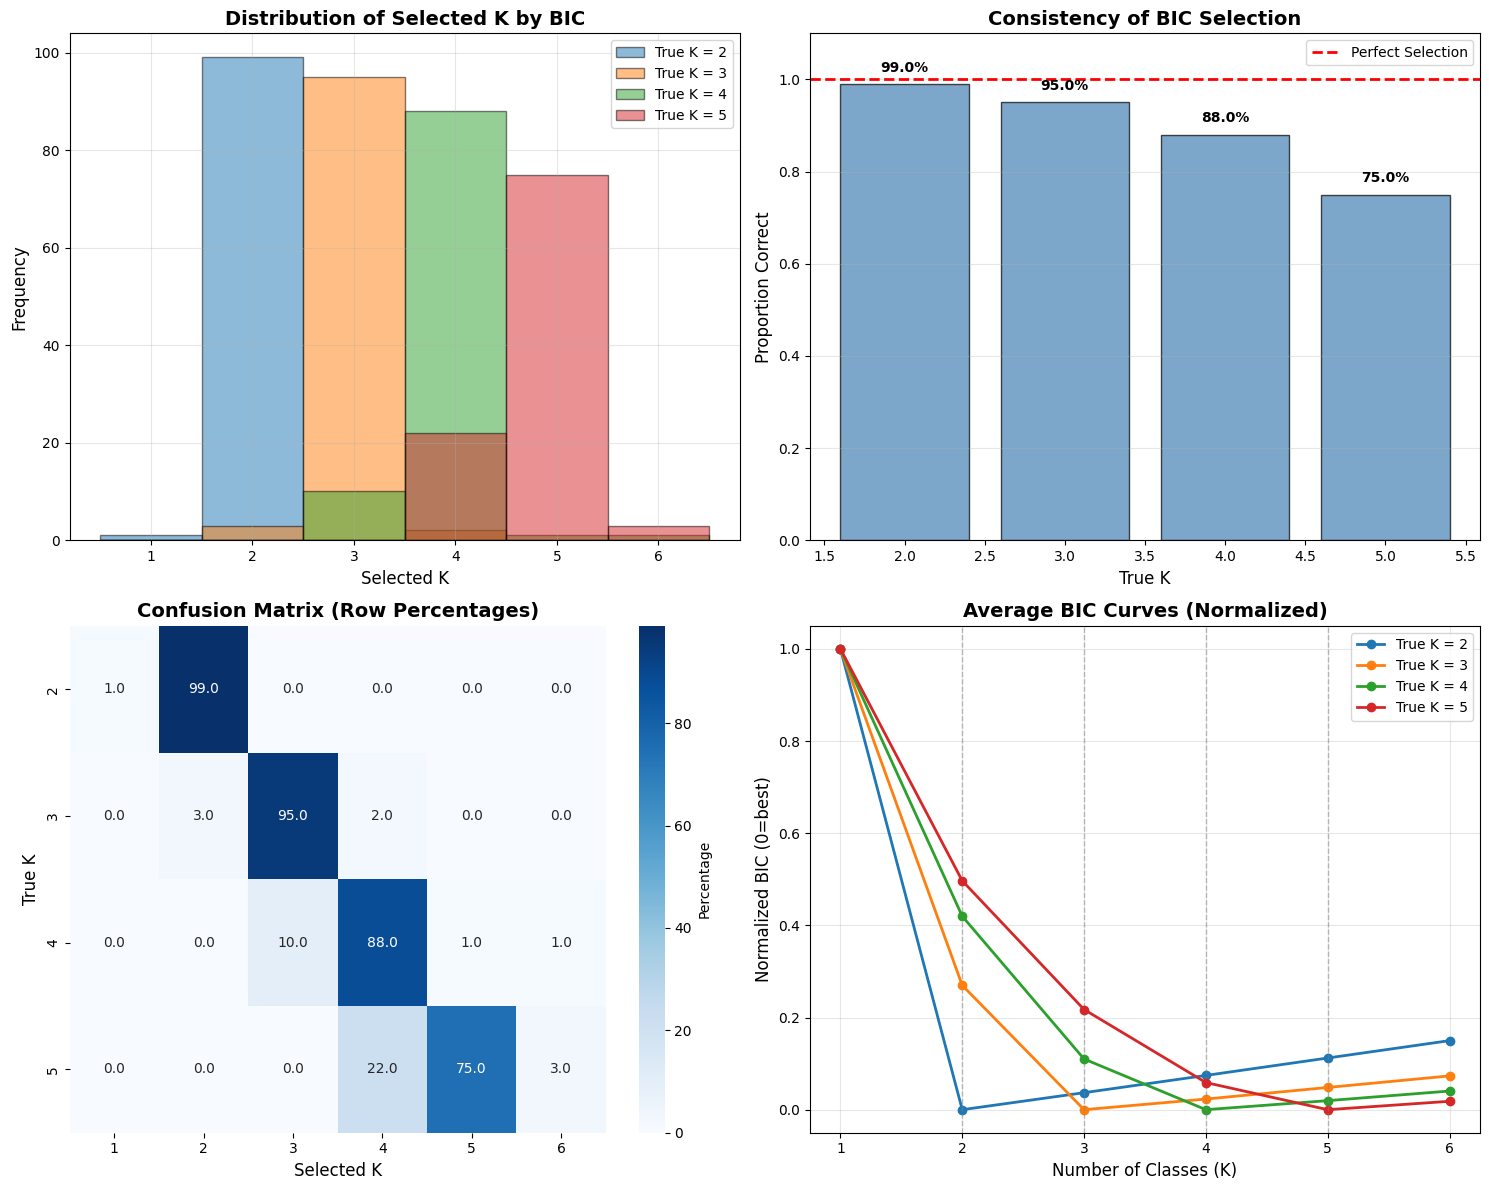

In [11]:
# Plot results
plot_results(results_df)

In [12]:
# Save detailed results
# Drop bic_values column for easier reading (it's an array)
results_to_save = results_df.drop(columns=['bic_values'])
results_to_save.to_csv('bic_simulation_detailed_results.csv', index=False)
print("Detailed results saved to: bic_simulation_detailed_results.csv")

Detailed results saved to: bic_simulation_detailed_results.csv


## 7. Additional Analysis: Example with Single Dataset

In [13]:
# Generate a single example dataset
print("Example: BIC model selection on a single dataset")
print("=" * 60)
print()

K_true_example = 4
X_example, H_example, pi_true_example, theta_true_example = generate_latent_class_data(
    n=CONFIG['n'], K=K_true_example, m=CONFIG['m'], C=CONFIG['C'], random_state=12345
)

print(f"Generated data with true K = {K_true_example}")
print(f"True mixture weights: {pi_true_example}")
print()

# Fit models for different K values
K_range = np.arange(1, CONFIG['K_max'] + 1)
bic_example = []
log_lik_example = []

for K in K_range:
    print(f"Fitting model with K = {K}...", end=" ")
    model = LatentClassModel(K, CONFIG['m'], CONFIG['C'], 
                             max_iter=CONFIG['max_iter'], tol=CONFIG['tol'], random_state=42)
    model.fit(X_example)
    bic = model.compute_bic(X_example)
    log_lik = model._compute_log_likelihood(X_example)
    bic_example.append(bic)
    log_lik_example.append(log_lik)
    print(f"BIC = {bic:.2f}, Log-likelihood = {log_lik:.2f}")

K_selected_example = K_range[np.argmin(bic_example)]
print()
print(f"Selected K by BIC: {K_selected_example}")
print(f"True K: {K_true_example}")
print(f"Selection {'CORRECT' if K_selected_example == K_true_example else 'INCORRECT'}")
print()

Example: BIC model selection on a single dataset

Generated data with true K = 4
True mixture weights: [0.76561101 0.1097289  0.06602552 0.05863457]

Fitting model with K = 1... BIC = 152166.61, Log-likelihood = -75779.27
Fitting model with K = 2... BIC = 144225.41, Log-likelihood = -71500.83
Fitting model with K = 3... BIC = 142511.93, Log-likelihood = -70336.25
Fitting model with K = 4... BIC = 145177.42, Log-likelihood = -71361.16
Fitting model with K = 5... BIC = 142717.96, Log-likelihood = -69823.60
Fitting model with K = 6... BIC = 143288.46, Log-likelihood = -69801.01

Selected K by BIC: 3
True K: 4
Selection INCORRECT



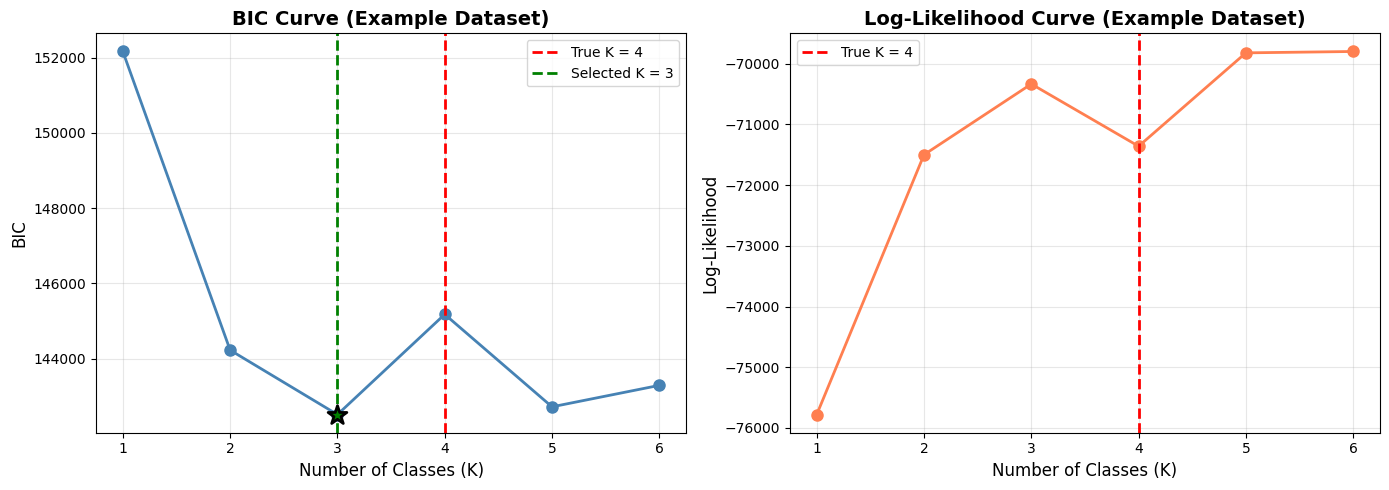

In [14]:
# Plot BIC curve for example
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BIC curve
ax = axes[0]
ax.plot(K_range, bic_example, marker='o', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=K_true_example, color='red', linestyle='--', linewidth=2, label=f'True K = {K_true_example}')
ax.axvline(x=K_selected_example, color='green', linestyle='--', linewidth=2, label=f'Selected K = {K_selected_example}')
ax.scatter([K_selected_example], [bic_example[K_selected_example-1]], 
           color='green', s=200, zorder=5, marker='*', edgecolors='black', linewidths=2)
ax.set_xlabel('Number of Classes (K)', fontsize=12)
ax.set_ylabel('BIC', fontsize=12)
ax.set_title('BIC Curve (Example Dataset)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Log-likelihood curve
ax = axes[1]
ax.plot(K_range, log_lik_example, marker='o', linewidth=2, markersize=8, color='coral')
ax.axvline(x=K_true_example, color='red', linestyle='--', linewidth=2, label=f'True K = {K_true_example}')
ax.set_xlabel('Number of Classes (K)', fontsize=12)
ax.set_ylabel('Log-Likelihood', fontsize=12)
ax.set_title('Log-Likelihood Curve (Example Dataset)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bic_example_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Notes on BIC Consistency

### BIC Formula
$$\text{BIC} = -2 \log L(\Theta | X) + p \log n$$

where:
- $L(\Theta | X)$ is the likelihood
- $p$ is the number of free parameters: $(K-1) + \sum_{r=1}^m K(C_r - 1)$
- $n$ is the sample size

### Interpretation of Results
- **Consistency**: BIC is known to be consistent for model selection, meaning as $n \to \infty$, $P(\hat{K} = K_0) \to 1$
- **Finite sample performance**: The simulation studies show how well BIC performs with finite samples
- **High proportion correct**: Indicates BIC is effective for the given sample size and model configuration
- **Patterns of misselection**: If BIC tends to underselect or overselect, this provides insight into finite-sample behavior